In [1]:
import numpy as np
import scipy.interpolate as intp
%matplotlib inline
import matplotlib as mpl, matplotlib.pyplot as plt

mpl.rc('font', size=18)
mpl.rc('figure', figsize=(12,6))

In [2]:
def massconc_xint(xval, steps):
    """
    Numerically integrate Equation 12 from Prada et al. 2012 over x
    """
    xint = 0.0

    xarr = np.linspace(0.0,xval,steps)

    for x in range(0,steps-1):
        xint += 0.5*( (xarr[x+1]/(1.0+xarr[x+1]**3.0))**1.5 + (xarr[x]/(1.0+xarr[x]**3.0))**1.5 ) * (xarr[x+1]-xarr[x])
    return xint

In [3]:
# Prada 12 Mvir-c relation 

def cmin_prada(xv):
    return 3.681 + (5.033-3.681)*(0.5 + np.arctan(6.948*(xv-0.424))/np.pi)

def invsigmin_prada(xv):
    return 1.047 + (1.646-1.047)*(0.5 + np.arctan(7.386*(xv-0.526))/np.pi)

def massconc_Prada12(mvir, cosmopar, redshift=3, steps=100000):
    """
    Prada et al. (2012), MNRAS, 423, 3018
    """
    xval = ((cosmopar[2]/cosmopar[3])**(1.0/3.0))/(1.0+redshift) # Eq 13
    yval = 1.0/(mvir/(1.0E12/cosmopar[0])) # Eq 23b
    xintg = massconc_xint(xval,steps)
    Dx = 2.5 * (cosmopar[3]/cosmopar[2])**(1.0/3.0) * np.sqrt(1.0 + xval**3) * xintg /xval**1.5 # Eq 12
    Bzero = cmin_prada(xval)/cmin_prada(1.393) # Eq18a
    Bone  = invsigmin_prada(xval)/invsigmin_prada(1.393) # Eq 18b
    sigfunc = Dx * 16.9 * yval**0.41 / ( 1.0 + 1.102*(yval**0.20) + 6.22*(yval**0.333) ) # Eq 23a
    sigdash = Bone * sigfunc  # Eq 15
    Csigdash = 2.881 * (1.0 + (sigdash/1.257)**1.022) * np.exp(0.060 / sigdash**2)  # Eq 16
    conc = Bzero * Csigdash
    return conc

def get_cosmo(use="planck"):
    if use.lower() == "planck":
        hubble = 0.673
        Omega_b = 0.02224/hubble**2
        Omega_m = 0.315
        Omega_l = 1.0-Omega_m
    else:
        # Use Planck as default
        hubble = 0.673
        Omega_b = 0.02224/hubble**2
        Omega_m = 0.315
        Omega_l = 1.0-Omega_m
    cosmopar = np.array([hubble,Omega_b,Omega_l,Omega_m])
    return cosmopar

cpar = get_cosmo()

In [4]:
# Eagle Mvir-c relation
cfile = np.loadtxt('../data/Planck_cMz.dat')
ms = np.log10(10**cfile[:,0] * cpar[0] * 10**10)
cps = cfile[:,1]
massconc_Eagle = intp.interp1d(10**ms, cps)

In [5]:
# Make standardised grids of concentration parameters
# for the BL gas density model code
grid_mass = np.logspace(7, 9.65, 2651)
grid_prada = massconc_Prada12(grid_mass, cpar, 0)
grid_eagle = massconc_Eagle(grid_mass)

np.savetxt('../data/Mvir_c_Eagle.dat', np.column_stack([grid_mass, grid_eagle]))
np.savetxt('../data/Mvir_c_Prada.dat', np.column_stack([grid_mass, grid_prada]))

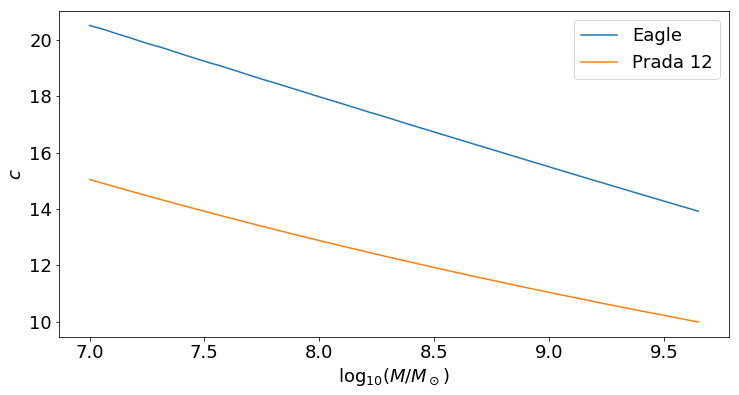

In [6]:
masses = np.logspace(8, 9.65, 20)

plt.figure()
ax = plt.gca()
ax.set_xlabel(r'$\log_{10}(M/M_\odot)$')
ax.set_ylabel(r'$c$')
plt.plot(np.log10(grid_mass), grid_eagle, label='Eagle')
plt.plot(np.log10(grid_mass), grid_prada, label='Prada 12')
plt.legend();

In [8]:
massconc_Prada12(10**9.0725, cpar, 0)

10.922312892867197